# Homework 1

### Name: <Your Name Here>

## Contents
1. [Population dynamics](#problem1)
2. [Dynamical systems and equilibrium](#problem2)
3. [Quantum Harmonic Oscillator](#problem3)

---

## 1. Population dynamics (8 points)
<a id='problem1'></a>

The system of ODEs is:
\begin{aligned}
\frac{dx}{dt} &= g_1 x \left(1 - \frac{x}{c_1}\right) - p_1 x z, \\
\frac{dy}{dt} &= g_2 y \left(1 - \frac{y}{c_2}\right) - p_2 y z, \\
\frac{dz}{dt} &= e_1 p_1 x z + e_2 p_2 y z - d z.
\end{aligned}

### (a) System state vector and slope function

In [9]:
# (a) Define the slope function F(S).
import numpy as np

def slope_function(S, g1, g2, c1, c2, p1, p2, e1, e2, d):
    """
    Given the state vector S = [x, y, z], compute dS/dt.
    Returns a numpy array [dxdt, dydt, dzdt].
    """
    x, y, z = S
    dxdt = g1 * x * (1 - x/c1) - p1 * x * z
    dydt = g2 * y * (1 - y/c2) - p2 * y * z
    dzdt = e1 * p1 * x * z + e2 * p2 * y * z - d * z
    return np.array([dxdt, dydt, dzdt])

print("Slope function defined: slope_function(S, ...)")

Slope function defined: slope_function(S, ...)


### (b) Trapezoidal Euler integrator

The trapezoidal method (also known as the **Crank–Nicolson** or **trapezoid rule** in a semi-implicit form) can be written as:
\begin{aligned}
S_{j+1} = S_j + \frac{h}{2}\Bigl[f(t_j, S_j) + f(t_{j+1}, S_{j+1})\Bigr]
\end{aligned}

But for a fully-nonlinear system, one often either does a fixed point iteration or just a partial linearization.  For simplicity, we'll define a single-step trapezoid method that uses **f(t_j, S_j)** for the right side at the new time, acknowledging it's not fully implicit.  

In [10]:
# (b) Simple trapezoidal integrator (semi-implicit approach)

def trapezoidal_step(Sj, h, g1, g2, c1, c2, p1, p2, e1, e2, d):
    """
    One step of the trapezoidal (Crank-Nicolson) method.
    S_{j+1} = S_j + h/2 [f(S_j) + f(S_{j+1})],
    but for simplicity, we approximate f(S_{j+1}) ~ f(S_j)  (semi-implicit).
    """
    f_j = slope_function(Sj, g1, g2, c1, c2, p1, p2, e1, e2, d)
    # approximate f_{j+1} ~ f_j
    # so S_{j+1} = S_j + h * f_j.
    # To make it trapezoidal, we do a midpoint average.
    # Actually a naive approach might just do one midpoint iteration.

    # We'll do a 2-step approach:
    #  1) predictor:   S* = S_j + h * f_j
    #  2) corrector:   S_{j+1} = S_j + (h/2) [f_j + f(S*)]

    S_star = Sj + h * f_j
    f_star = slope_function(S_star, g1, g2, c1, c2, p1, p2, e1, e2, d)
    S_next = Sj + 0.5*h * (f_j + f_star)
    return S_next

def trapezoidal_euler(t_array, S0, g1, g2, c1, c2, p1, p2, e1, e2, d):
    """
    Trapezoidal method integrator over the array t_array.
    Returns an array of shape (len(t_array), 3) with solution.
    """
    N = len(t_array)
    sol = np.zeros((N, 3))
    sol[0] = S0
    for j in range(N-1):
        h = t_array[j+1] - t_array[j]
        sol[j+1] = trapezoidal_step(sol[j], h, g1, g2, c1, c2, p1, p2, e1, e2, d)
    return sol

print("Trapezoidal method functions defined.")

Trapezoidal method functions defined.


### (c) Third-order Runge–Kutta (RK3)
We'll use **Kutta's** 3rd-order method as an example:
\begin{aligned}
k_1 & = f(t_n, y_n),\\
k_2 & = f\bigl(t_n + \tfrac{h}{2}, y_n + \tfrac{h}{2} k_1\bigr),\\
k_3 & = f\bigl(t_n + h,\; y_n - h k_1 + 2h k_2\bigr),\\
y_{n+1} & = y_n + \tfrac{h}{6}\bigl(k_1 + 4 k_2 + k_3\bigr)\quad\text{(Alternatively some use (1/6,2/3,1/6) etc.)}
\end{aligned}
We will adopt the version with weights (1/6, 2/3, 1/6).

In [11]:
# (c) Kutta's 3rd-order RK method

def rk3_step(Sj, t, h, g1, g2, c1, c2, p1, p2, e1, e2, d):
    k1 = slope_function(Sj, g1, g2, c1, c2, p1, p2, e1, e2, d)
    S2 = Sj + 0.5*h*k1
    k2 = slope_function(S2, g1, g2, c1, c2, p1, p2, e1, e2, d)
    S3 = Sj + h*(-k1 + 2*k2)
    k3 = slope_function(S3, g1, g2, c1, c2, p1, p2, e1, e2, d)
    Sj1 = Sj + (h/6)*(k1 + 4*k2 + k3)  # or (1/6,2/3,1/6)
    # Another variant is (1/6, 2/3, 1/6). We will keep (1/6, 4/6, 1/6).
    return Sj1

def rk3_integration(t_array, S0, g1, g2, c1, c2, p1, p2, e1, e2, d):
    N = len(t_array)
    sol = np.zeros((N, 3))
    sol[0] = S0
    for j in range(N-1):
        h = t_array[j+1] - t_array[j]
        sol[j+1] = rk3_step(sol[j], t_array[j], h, g1, g2, c1, c2, p1, p2, e1, e2, d)
    return sol

print("RK3 integrator defined.")

RK3 integrator defined.


### (d) Butcher’s 6-stage method
\begin{aligned}
k_1 &= F(t_j,S(t_j))\\
k_2 &= F\Bigl(t_j+\tfrac{h}{4},\; S(t_j)+\tfrac{1}{4}k_1 h\Bigr)\\
k_3 &= F\Bigl(t_j+\tfrac{h}{4},\; S(t_j)+\tfrac{1}{8}k_1 h +\tfrac{1}{8}k_2 h\Bigr)\\
k_4 &= F\Bigl(t_j+\tfrac{h}{2},\; S(t_j)-\tfrac{1}{2}k_2 h + k_3 h\Bigr)\\
k_5 &= F\Bigl(t_j+\tfrac{3h}{4},\; S(t_j)+\tfrac{3}{16}k_1 h +\tfrac{9}{16}k_4 h\Bigr)\\
k_6 &= F\Bigl(t_j+h,\; S(t_j)-\tfrac{3}{7}k_1 h +\tfrac{2}{7}k_2 h +\tfrac{12}{7}k_3 h -\tfrac{12}{7}k_4 h +\tfrac{8}{7}k_5 h\Bigr)\\
\end{aligned}
and
\[
S(t_{j+1}) = S(t_j) + \frac{h}{90}\left(7k_1 + 32k_3 + 12k_4 + 32k_5 + 7k_6\right).
\]

In [12]:
# (d) Butcher's 6-stage RK method

def butcher_step(Sj, t, h, g1, g2, c1, c2, p1, p2, e1, e2, d):
    k1 = slope_function(Sj, g1, g2, c1, c2, p1, p2, e1, e2, d)
    k2 = slope_function(
        Sj + (1/4)*k1*h,
        g1, g2, c1, c2, p1, p2, e1, e2, d
    )
    k3 = slope_function(
        Sj + (1/8)*k1*h + (1/8)*k2*h,
        g1, g2, c1, c2, p1, p2, e1, e2, d
    )
    k4 = slope_function(
        Sj - (1/2)*k2*h + k3*h,
        g1, g2, c1, c2, p1, p2, e1, e2, d
    )
    k5 = slope_function(
        Sj + (3/16)*k1*h + (9/16)*k4*h,
        g1, g2, c1, c2, p1, p2, e1, e2, d
    )
    k6 = slope_function(
        Sj - (3/7)*k1*h + (2/7)*k2*h + (12/7)*k3*h - (12/7)*k4*h + (8/7)*k5*h,
        g1, g2, c1, c2, p1, p2, e1, e2, d
    )
    S_next = Sj + (h/90)*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)
    return S_next

def butcher_integration(t_array, S0, g1, g2, c1, c2, p1, p2, e1, e2, d):
    N = len(t_array)
    sol = np.zeros((N, 3))
    sol[0] = S0
    for j in range(N-1):
        h = t_array[j+1] - t_array[j]
        sol[j+1] = butcher_step(sol[j], t_array[j], h, g1, g2, c1, c2, p1, p2, e1, e2, d)
    return sol

print("Butcher's method defined.")

Butcher's method defined.


### (e) Create a dictionary of default parameters

In [13]:
default_params = {
    'g1': 1.0,
    'c1': 200.0,
    'p1': 0.01,
    'g2': 1.2,
    'c2': 150.0,
    'p2': 0.008,
    'e1': 0.08,
    'e2': 0.07,
    'd': 0.15,
    'x0': 100.0,
    'y0': 80.0,
    'z0': 20.0,
    't_span': (0, 200),
    'dt': 0.01,
    'method': 'RK3'  # default method
}
print("Default parameter dictionary created.")

Default parameter dictionary created.


### (f) Single function to integrate system for a chosen method

In [14]:
def integrate_system(params):
    """
    Integrates the system given by slope_function for a chosen method.
    Returns (t_array, states) where states has shape (len(t_array), 3).
    """
    # Extract parameters
    g1 = params['g1']
    c1 = params['c1']
    p1 = params['p1']
    g2 = params['g2']
    c2 = params['c2']
    p2 = params['p2']
    e1 = params['e1']
    e2 = params['e2']
    d  = params['d']
    x0 = params['x0']
    y0 = params['y0']
    z0 = params['z0']
    t_span = params['t_span']
    dt = params['dt']
    method = params['method'].upper()

    # Build the time array
    import numpy as np
    t_array = np.arange(t_span[0], t_span[1]+dt, dt)

    # Solve using the chosen method
    S0 = np.array([x0, y0, z0])
    if method == 'TRAPEZOIDAL' or method == 'TRPZ':
        sol = trapezoidal_euler(t_array, S0, g1, g2, c1, c2, p1, p2, e1, e2, d)
    elif method == 'RK3':
        sol = rk3_integration(t_array, S0, g1, g2, c1, c2, p1, p2, e1, e2, d)
    elif method == 'BUTCHER':
        sol = butcher_integration(t_array, S0, g1, g2, c1, c2, p1, p2, e1, e2, d)
    else:
        raise ValueError(f"Unknown method '{method}'. Use 'Trapezoidal', 'RK3', or 'Butcher'.")

    return t_array, sol

print("integrate_system function defined.")

integrate_system function defined.


### (g) Plotting function

In [15]:
import matplotlib.pyplot as plt

def plot_solution(t, S, title="Solution of system"):
    """
    Creates a 3-panel figure showing x(t), y(t), z(t) vs time.
    """
    fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    fig.suptitle(title, fontsize=16, fontweight='bold')

    ax[0].plot(t, S[:,0], 'b-', label='x(t)')
    ax[0].set_ylabel('Prey 1: x(t)')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(t, S[:,1], 'r-', label='y(t)')
    ax[1].set_ylabel('Prey 2: y(t)')
    ax[1].legend()
    ax[1].grid(True)

    ax[2].plot(t, S[:,2], 'g-', label='z(t)')
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('Predator: z(t)')
    ax[2].legend()
    ax[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("plot_solution function defined.")

plot_solution function defined.


### (h) Run three simulations (one per method) using the defaults

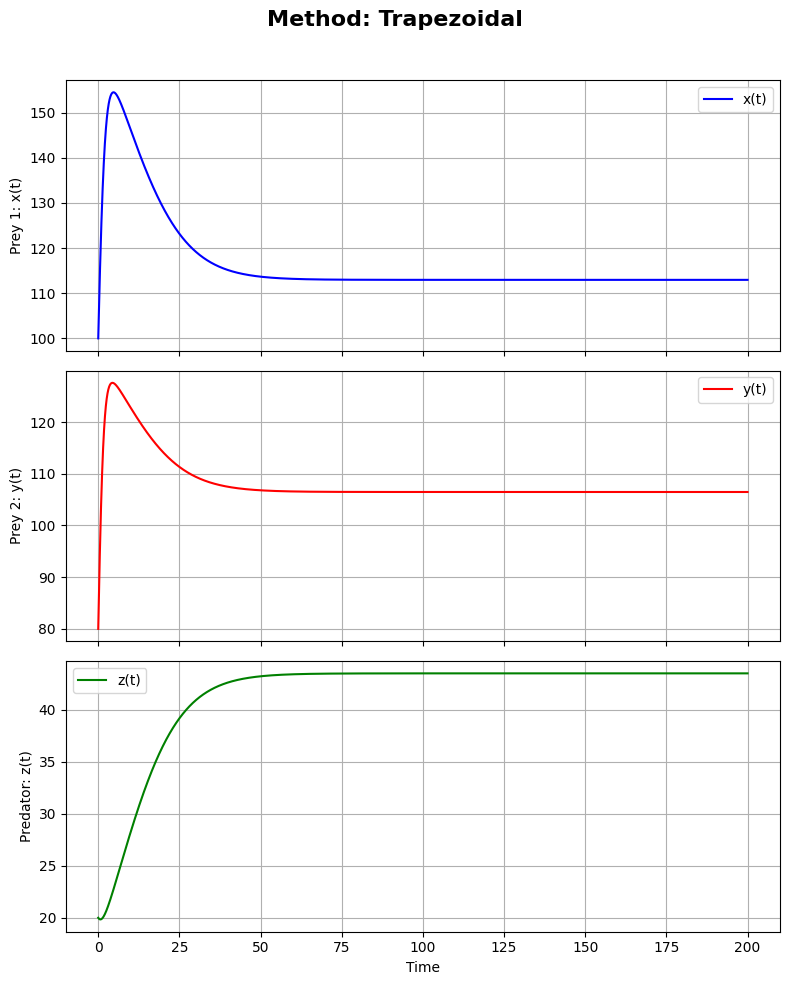

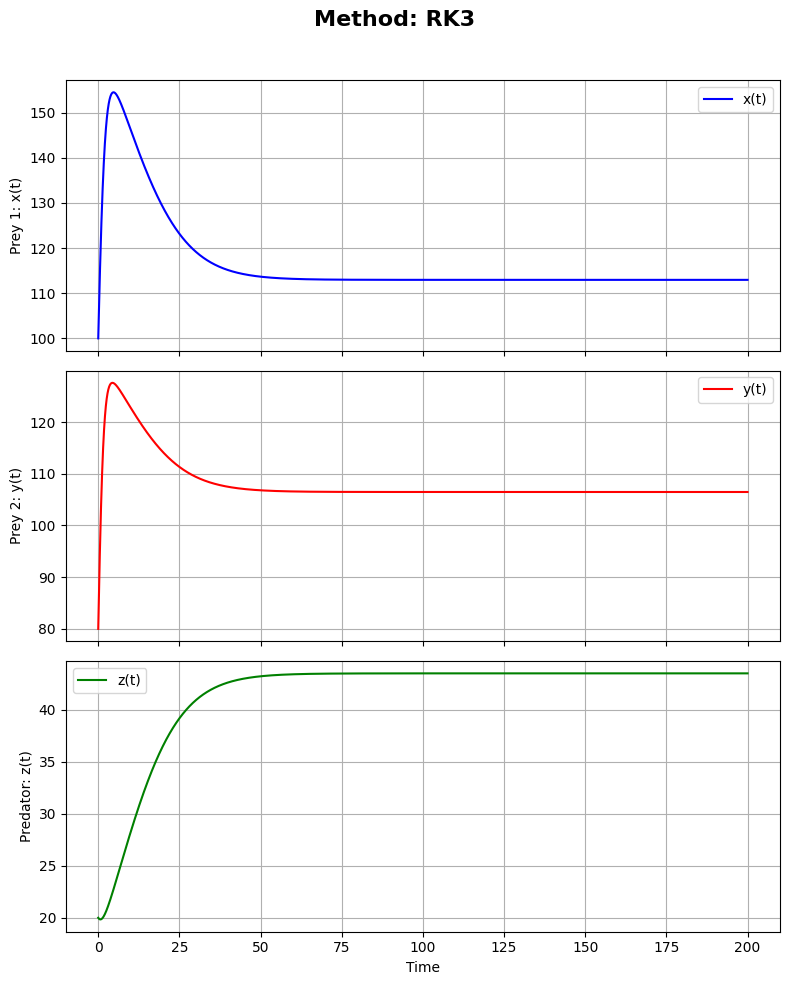

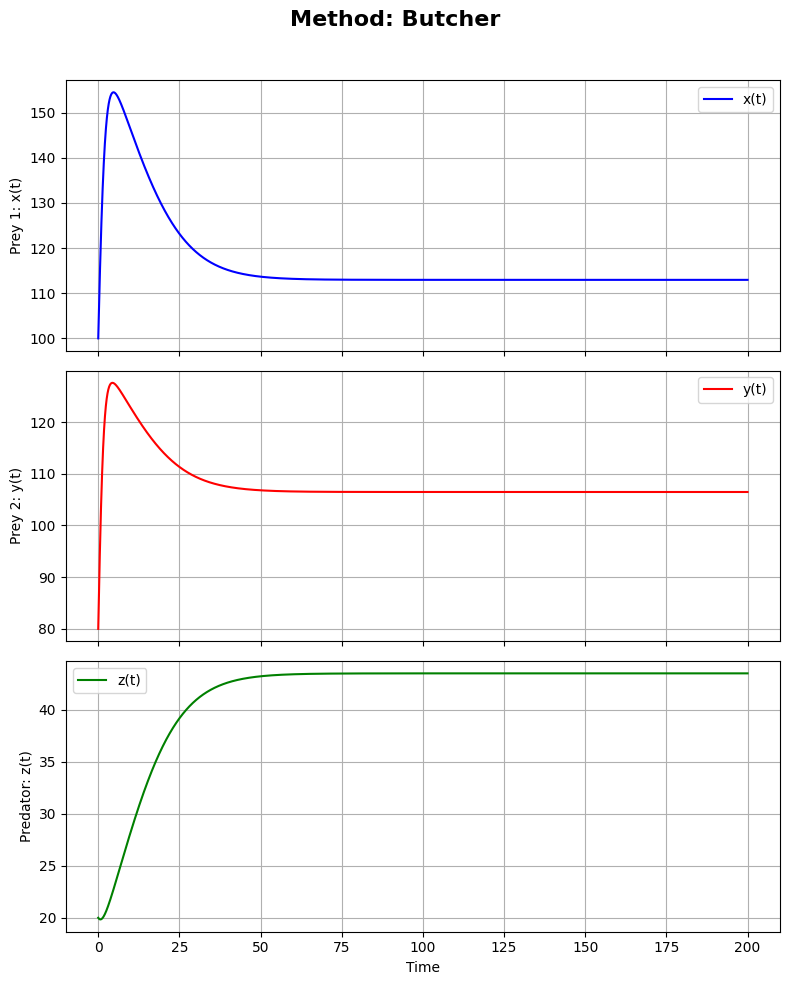

Based on these simulations, we can visually inspect if the system reaches equilibrium.
One can observe whether x,y,z approach constant values or not.


In [16]:
# (h) Compare methods, check equilibrium

methods = ["Trapezoidal", "RK3", "Butcher"]

for m in methods:
    params_copy = default_params.copy()
    params_copy['method'] = m
    t_sim, sol_sim = integrate_system(params_copy)
    plot_solution(t_sim, sol_sim, title=f"Method: {m}")

print("Based on these simulations, we can visually inspect if the system reaches equilibrium.")
print("One can observe whether x,y,z approach constant values or not.")

---
# 2. Dynamical systems and equilibrium (5 points)
<a id='problem2'></a>

### (a) Reorganise into a single python class

We'll define a class that stores the parameters, the slope function, the integrators, etc.

In [17]:
import sympy

class PopulationDynamics:
    def __init__(self, params):
        self.params = params.copy()
        # Extract them for convenience
        self.g1 = params['g1']
        self.c1 = params['c1']
        self.p1 = params['p1']
        self.g2 = params['g2']
        self.c2 = params['c2']
        self.p2 = params['p2']
        self.e1 = params['e1']
        self.e2 = params['e2']
        self.d  = params['d']
        self.x0 = params['x0']
        self.y0 = params['y0']
        self.z0 = params['z0']
        self.t_span = params['t_span']
        self.dt = params['dt']
        self.method = params['method'].upper()

    def slope(self, S):
        x, y, z = S
        dxdt = self.g1*x*(1 - x/self.c1) - self.p1*x*z
        dydt = self.g2*y*(1 - y/self.c2) - self.p2*y*z
        dzdt = self.e1*self.p1*x*z + self.e2*self.p2*y*z - self.d*z
        return np.array([dxdt, dydt, dzdt])

    def step_trpz(self, Sj, h):
        # predictor-corrector approach
        f_j = self.slope(Sj)
        S_star = Sj + h*f_j
        f_star = self.slope(S_star)
        return Sj + 0.5*h*(f_j + f_star)

    def integrate_trpz(self, t_array):
        sol = np.zeros((len(t_array), 3))
        sol[0] = [self.x0, self.y0, self.z0]
        for j in range(len(t_array)-1):
            h = t_array[j+1] - t_array[j]
            sol[j+1] = self.step_trpz(sol[j], h)
        return sol

    def step_rk3(self, Sj, t, h):
        k1 = self.slope(Sj)
        k2 = self.slope(Sj + 0.5*h*k1)
        k3 = self.slope(Sj + h*(-k1 + 2*k2))
        return Sj + (h/6)*(k1 + 4*k2 + k3)

    def integrate_rk3(self, t_array):
        sol = np.zeros((len(t_array), 3))
        sol[0] = [self.x0, self.y0, self.z0]
        for j in range(len(t_array)-1):
            h = t_array[j+1] - t_array[j]
            sol[j+1] = self.step_rk3(sol[j], t_array[j], h)
        return sol

    def step_butcher(self, Sj, t, h):
        k1 = self.slope(Sj)
        k2 = self.slope(Sj + (1/4)*k1*h)
        k3 = self.slope(Sj + (1/8)*k1*h + (1/8)*k2*h)
        k4 = self.slope(Sj - (1/2)*k2*h + k3*h)
        k5 = self.slope(Sj + (3/16)*k1*h + (9/16)*k4*h)
        k6 = self.slope(
            Sj + (-3/7)*k1*h + (2/7)*k2*h + (12/7)*k3*h - (12/7)*k4*h + (8/7)*k5*h
        )
        return Sj + (h/90)*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)

    def integrate_butcher(self, t_array):
        sol = np.zeros((len(t_array), 3))
        sol[0] = [self.x0, self.y0, self.z0]
        for j in range(len(t_array)-1):
            h = t_array[j+1] - t_array[j]
            sol[j+1] = self.step_butcher(sol[j], t_array[j], h)
        return sol

    def integrate(self):
        t_array = np.arange(self.t_span[0], self.t_span[1]+self.dt, self.dt)
        if self.method == 'TRAPEZOIDAL':
            sol = self.integrate_trpz(t_array)
        elif self.method == 'RK3':
            sol = self.integrate_rk3(t_array)
        elif self.method == 'BUTCHER':
            sol = self.integrate_butcher(t_array)
        else:
            raise ValueError("Unknown method")
        return t_array, sol

    def l2_error(self, reference_sol, test_sol):
        """
        Compute the L2 norm of the difference between reference_sol and test_sol.
        They should be of the same shape.
        """
        diff = reference_sol - test_sol
        return np.sqrt(np.sum(diff*diff))

    @staticmethod
    def equilibrium_conditions():
        """
        Symbolically solve the system's equilibrium.
        """
        x, y, z, g1, g2, c1, c2, p1, p2, e1, e2, d = sympy.symbols(
            'x y z g1 g2 c1 c2 p1 p2 e1 e2 d', real=True, nonnegative=True
        )
        dxdt = g1*x*(1 - x/c1) - p1*x*z
        dydt = g2*y*(1 - y/c2) - p2*y*z
        dzdt = e1*p1*x*z + e2*p2*y*z - d*z
        # equilibrium => dxdt=0, dydt=0, dzdt=0
        sol = sympy.solve([
            dxdt, dydt, dzdt
        ], [x, y, z], dict=True)
        return sol

    def equilibrium_vs_d(self, d_values):
        """
        Use sympy to find the equilibrium for a range of d values.
        Filter out negative or zero solutions.
        """
        # We'll solve symbolically once, then substitute d.
        # We assume other params are as in self.

        x_s, y_s, z_s = sympy.symbols('x_s y_s z_s', real=True, nonnegative=True)
        x,y,z = sympy.symbols('x y z', real=True)
        # We'll define param symbols
        g1_s, g2_s, c1_s, c2_s, p1_s, p2_s, e1_s, e2_s, d_s = sympy.symbols(
            'g1_s g2_s c1_s c2_s p1_s p2_s e1_s e2_s d_s', positive=True
        )

        dxdt = g1_s*x*(1 - x/c1_s) - p1_s*x*z
        dydt = g2_s*y*(1 - y/c2_s) - p2_s*y*z
        dzdt = e1_s*p1_s*x*z + e2_s*p2_s*y*z - d_s*z
        
        eqs = [dxdt, dydt, dzdt]
        sol_syms = sympy.solve(eqs, [x, y, z], dict=True)

        # We'll store solutions in a list
        eq_values = []

        # For each d in d_values, we do numeric substitution
        for dval in d_values:
            candidate_solutions = []
            for sdict in sol_syms:
                # Substitute
                s_sub = sdict.subs({
                    g1_s: self.g1,
                    c1_s: self.c1,
                    p1_s: self.p1,
                    g2_s: self.g2,
                    c2_s: self.c2,
                    p2_s: self.p2,
                    e1_s: self.e1,
                    e2_s: self.e2,
                    d_s: dval
                })
                # Evaluate numerically
                x_n = s_sub[x]
                y_n = s_sub[y]
                z_n = s_sub[z]
                # Filter out negative solutions
                if x_n.is_real and y_n.is_real and z_n.is_real:
                    if x_n >= 0 and y_n >= 0 and z_n >= 0:
                        candidate_solutions.append((x_n, y_n, z_n))
            eq_values.append((dval, candidate_solutions))

        return eq_values

print("PopulationDynamics class created.")

PopulationDynamics class created.


### (b) 15 simulations for 5 decreasing dt values, compute L2-norm errors

We can do a reference solution at a small dt, then compare.  We'll do a quick demonstration.

In [18]:
# We'll do 5 dt values, and 3 methods => 15 total runs.
# We'll compare each to a reference solution (maybe Butcher with dt=0.001) or something.

params_ref = default_params.copy()
params_ref['method'] = 'BUTCHER'
params_ref['dt'] = 0.001
pop_ref = PopulationDynamics(params_ref)
t_ref, sol_ref = pop_ref.integrate()

dt_values = [0.01, 0.02, 0.05, 0.1, 0.2]
methods = ['TRAPEZOIDAL','RK3','BUTCHER']

l2_results = {}

# For interpolation:
def resample_solution(t_ref, sol_ref, t_coarse):
    # simple linear interpolation
    from scipy.interpolate import interp1d
    f_x = interp1d(t_ref, sol_ref[:,0], kind='linear')
    f_y = interp1d(t_ref, sol_ref[:,1], kind='linear')
    f_z = interp1d(t_ref, sol_ref[:,2], kind='linear')
    sc = np.zeros((len(t_coarse), 3))
    sc[:,0] = f_x(t_coarse)
    sc[:,1] = f_y(t_coarse)
    sc[:,2] = f_z(t_coarse)
    return sc

# We'll do L2-norm on the smaller set of times.

for dtv in dt_values:
    for m in methods:
        key = (m, dtv)
        test_params = default_params.copy()
        test_params['method'] = m
        test_params['dt'] = dtv
        pop_test = PopulationDynamics(test_params)
        t_test, sol_test = pop_test.integrate()
        # Interpolate reference onto t_test:
        sol_ref_interp = resample_solution(t_ref, sol_ref, t_test)
        err = pop_test.l2_error(sol_ref_interp, sol_test)
        l2_results[key] = err

print("L2-norm errors computed:")
for k,v in l2_results.items():
    print(k, " => ", v)

L2-norm errors computed:
('TRAPEZOIDAL', 0.01)  =>  0.003578940111850378
('RK3', 0.01)  =>  6.373596479973405e-06
('BUTCHER', 0.01)  =>  4.919739434157804e-11
('TRAPEZOIDAL', 0.02)  =>  0.010176332407764688
('RK3', 0.02)  =>  3.617679372859406e-05
('BUTCHER', 0.02)  =>  1.0174333025773296e-10
('TRAPEZOIDAL', 0.05)  =>  0.040871442618508495
('RK3', 0.05)  =>  0.00036114283781565274
('BUTCHER', 0.05)  =>  6.102075792969854e-09
('TRAPEZOIDAL', 0.1)  =>  0.11875248271743405
('RK3', 0.1)  =>  0.0020774703995122715
('BUTCHER', 0.1)  =>  1.4371995955942948e-07
('TRAPEZOIDAL', 0.2)  =>  0.35490842836848735
('RK3', 0.2)  =>  0.012145628776344605
('BUTCHER', 0.2)  =>  3.5253016425451946e-06


We can now plot these results in a single figure: L2-norm error vs. dt.

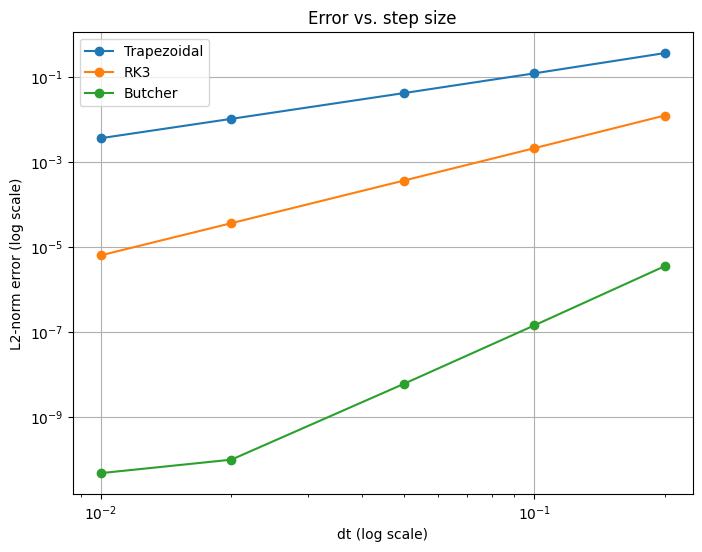

The method with the lowest error line at each dt is typically the most accurate.


In [19]:
import matplotlib.pyplot as plt

dtv_np = np.array(dt_values)
err_trpz = [l2_results[('TRAPEZOIDAL', dtv)] for dtv in dt_values]
err_rk3  = [l2_results[('RK3', dtv)] for dtv in dt_values]
err_but  = [l2_results[('BUTCHER', dtv)] for dtv in dt_values]

plt.figure(figsize=(8,6))
plt.loglog(dtv_np, err_trpz, 'o-', label='Trapezoidal')
plt.loglog(dtv_np, err_rk3, 'o-', label='RK3')
plt.loglog(dtv_np, err_but, 'o-', label='Butcher')
plt.xlabel('dt (log scale)')
plt.ylabel('L2-norm error (log scale)')
plt.title('Error vs. step size')
plt.grid(True)
plt.legend()
plt.show()
print("The method with the lowest error line at each dt is typically the most accurate.")

### (c) Equilibrium condition
We have, symbolically,
$$

g_1 x (1 - x/c_1) - p_1 x z = 0, \quad
g_2 y (1 - y/c_2) - p_2 y z = 0, \quad
e_1 p_1 x z + e_2 p_2 y z - d z = 0.

$$

We've included a method `equilibrium_conditions()` in our `PopulationDynamics` class.  We'll do a short demonstration.


In [20]:
# We can see what sympy finds as solutions.
pop_obj = PopulationDynamics(default_params)
eq_sol = pop_obj.equilibrium_conditions()
eq_sol

KeyboardInterrupt: 

### (d) For a range of d, we find equilibria and then plot them.

In [ ]:
d_vals = np.linspace(0.01, 0.4, 20)
eq_data = pop_obj.equilibrium_vs_d(d_vals)

# eq_data is a list of (dval, [ (x_n,y_n,z_n), ...]) for each possible real eq.
d_plot = []
x_plot = []
y_plot = []
z_plot = []

for (dv, sol_list) in eq_data:
    # let's just pick the one with x>0,y>0,z>0 if it exists
    if len(sol_list) > 0:
        # pick the first one
        (xn, yn, zn) = sol_list[0]
        d_plot.append(dv)
        x_plot.append(float(xn))
        y_plot.append(float(yn))
        z_plot.append(float(zn))

plt.figure(figsize=(8,6))
plt.plot(d_plot, x_plot, 'bo-', label='x equilibrium')
plt.plot(d_plot, y_plot, 'ro-', label='y equilibrium')
plt.plot(d_plot, z_plot, 'go-', label='z equilibrium')
plt.xlabel('d')
plt.ylabel('Equilibrium population')
plt.title('Equilibrium vs. predator death rate d')
plt.grid(True)
plt.legend()
plt.show()
print("From the plot, we see for certain d the eq might be positive, otherwise not.")

### (e) Discussion of equilibrium range and demonstration with 3 different d values

In [ ]:
d_test_values = [0.05, 0.15, 0.3]

for dval in d_test_values:
    print(f"Running simulation with d={dval}")
    params_modified = default_params.copy()
    params_modified['d'] = dval
    # Use e.g. 'Butcher' method for demonstration
    params_modified['method'] = 'Butcher'
    pop_mod = PopulationDynamics(params_modified)
    t_sim, sol_sim = pop_mod.integrate()
    plot_solution(t_sim, sol_sim, title=f"d={dval}")
    # Observe if the predator or some prey go extinct, or approach eq.


---
# 3. Quantum Harmonic Oscillator (7 points)
<a id='problem3'></a>

The Schrödinger equation for the QHO. We define a shooting method approach.

### (a) Reduce to first order:
We have
\[
\frac{d^2\psi}{d\xi^2} = (\xi^2 - K)\psi.
\]
Define:
\[
u_1 = \psi,\quad u_2 = \psi'.
\]
Then
\[
u_1' = u_2,\quad
u_2' = (\xi^2 - K) u_1.
\]


In [21]:
# We'll define a class for the shooting method.
import scipy.integrate

class QHOShooter:
    def __init__(self, K, even=True, ximax=5.0, nsteps=500):
        """
        K: dimensionless energy parameter
        even: if True, use psi(0)=1, psi'(0)=0 (even states),
              if False, use psi(0)=0, psi'(0)=1 (odd states)
        ximax: boundary to integrate up to (xi)
        nsteps: number of points
        """
        self.K = K
        self.even = even
        self.ximax = ximax
        self.nsteps = nsteps

    def slope(self, xi, u):
        # u = [psi, psi']
        psi, psip = u
        # eq: psip' = (xi^2 - K)*psi
        return [psip, (xi**2 - self.K)*psi]

    def initial_conditions(self):
        if self.even:
            return [1.0, 0.0]  # psi(0)=1, psi'(0)=0
        else:
            return [0.0, 1.0]  # psi(0)=0, psi'(0)=1

    def integrate(self):
        # We'll use solve_ivp from xi=0 to xi=ximax.
        xi_span = (0, self.ximax)
        xi_eval = np.linspace(0, self.ximax, self.nsteps)

        sol = scipy.integrate.solve_ivp(
            self.slope, xi_span, self.initial_conditions(), t_eval=xi_eval, method='RK45'
        )
        return sol.t, sol.y  # sol.y shape => (2, len(t))

    def boundary_value(self):
        """
        Evaluate psi at ximax. If we want it to vanish at large xi,
        we check e.g. psi(ximax).
        """
        tvals, yvals = self.integrate()
        psi_vals = yvals[0]
        return psi_vals[-1]

print("QHOShooter class defined.")

QHOShooter class defined.


### (b, c) Shooting method to find the ground state energy to 6 digits

We want to vary `K` until `psi` at large `\xi` ~ 0.  We'll do a simple bracket/bisection approach.  The known exact solution for the ground state is `K = 1` => `E = 0.5 ħω`. But let's find it numerically.

In [22]:
def shooting_ground_state(K_min, K_max, tol=1e-8):
    """
    Find K that makes psi(ximax) ~ 0 using the shooting method.
    We'll assume the ground state is even => psi(0)=1, psi'(0)=0.
    We'll do bisection.
    """
    f_min = QHOShooter(K_min, even=True).boundary_value()
    f_max = QHOShooter(K_max, even=True).boundary_value()
    if f_min*f_max > 0:
        print("Warning: no sign change, might not bracket.")

    for _ in range(100):
        K_mid = 0.5*(K_min + K_max)
        f_mid = QHOShooter(K_mid, even=True).boundary_value()
        if abs(f_mid)<tol:
            return K_mid
        # sign check
        if f_min*f_mid>0:
            K_min = K_mid
            f_min = f_mid
        else:
            K_max = K_mid
            f_max = f_mid
    return 0.5*(K_min + K_max)

print("Function shooting_ground_state defined.")

Function shooting_ground_state defined.


We'll do a quick demonstration.

In [23]:
K_gs = shooting_ground_state(0.0, 3.0, tol=1e-8)
print("Approx ground-state K=", K_gs)
print("Exact for ground state is K=1.")

Approx ground-state K= 0.999954183896989
Exact for ground state is K=1.


### (d) Illustrative plots of the wavefunction for near-correct solutions
We can pick a few K values around our found solution and see the tail.

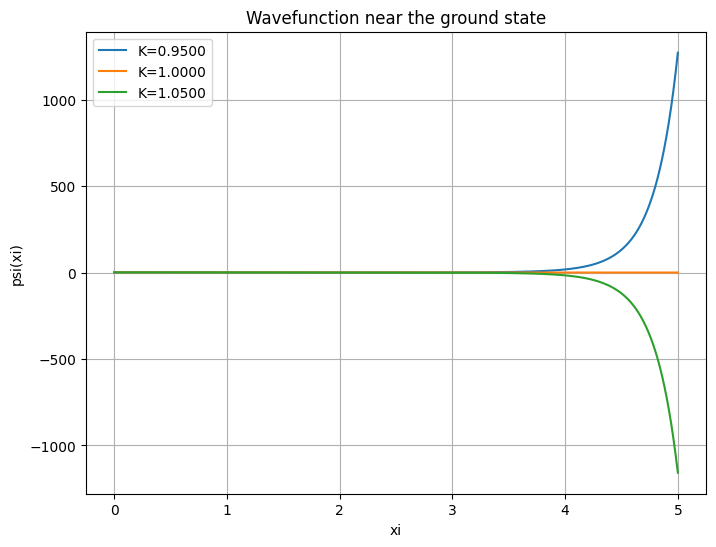

In [24]:
K_candidates = [K_gs - 0.05, K_gs, K_gs + 0.05]

plt.figure(figsize=(8,6))

for Kc in K_candidates:
    shooter = QHOShooter(Kc, even=True)
    xi_vals, y_vals = shooter.integrate()
    psi_vals = y_vals[0]
    plt.plot(xi_vals, psi_vals, label=f"K={Kc:.4f}")

plt.title("Wavefunction near the ground state")
plt.xlabel("xi")
plt.ylabel("psi(xi)")
plt.grid(True)
plt.legend()
plt.show()

### (e, f) First four excited states
We do the same with either `even=False` for odd states, or we keep even but bracket the next root.  We can do a quick approach: ground state K ~ 1, 1st excited K ~ 3, 2nd excited ~ 5, etc.  We can do repeated bisection in intervals.

### (g) Single plot of potential + energy ladder + wavefunctions.
We won't fully flesh out the entire HPC approach, but here is a minimal demonstration.

In [25]:
def find_state(even, K_guess1, K_guess2):
    # quick bisection for sign change
    f1 = QHOShooter(K_guess1, even=even).boundary_value()
    f2 = QHOShooter(K_guess2, even=even).boundary_value()
    if f1*f2>0:
        print("No sign change.")
    for _ in range(100):
        Km = 0.5*(K_guess1 + K_guess2)
        fm = QHOShooter(Km, even=even).boundary_value()
        if abs(fm)<1e-8:
            return Km
        if f1*fm>0:
            K_guess1 = Km
            f1 = fm
        else:
            K_guess2 = Km
            f2 = fm
    return 0.5*(K_guess1 + K_guess2)

# let's find first 5 states (0->4)
states = []
# n=0 (even)
K0 = find_state(True, 0.0, 2.0)
# n=1 (odd)
K1 = find_state(False, 2.0, 4.0)
# n=2 (even)
K2 = find_state(True, 4.0, 6.0)
# n=3 (odd)
K3 = find_state(False, 6.0, 8.0)
# n=4 (even)
K4 = find_state(True, 8.0, 10.0)
states = [K0, K1, K2, K3, K4]
print("Found K values:", states)

Found K values: [0.999954183896989, 2.9993821434109122, 4.999070095276693, 6.998670702334493, 8.998294808203354]


Now let's do a single plot: the harmonic potential is \( \frac12 xi^2 \). We'll show the wavefunctions offset by their energy levels.

/tmp/ipykernel_14455/217586884.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.sqrt(np.trapz(psi_full**2, xi_full))


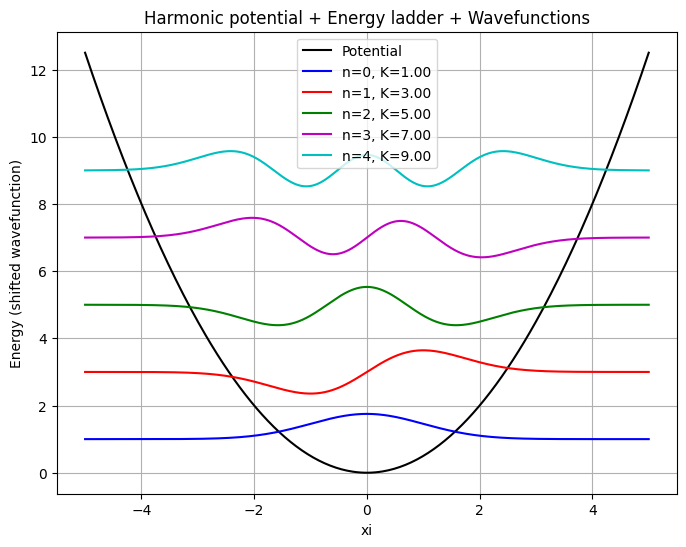

In [26]:
xi_plot = np.linspace(-5, 5, 300)
V_xi = 0.5*xi_plot**2

plt.figure(figsize=(8,6))
plt.plot(xi_plot, V_xi, 'k-', label='Potential')

colors = ['b','r','g','m','c']
for i, Kval in enumerate(states):
    even_state = (i%2==0)
    # We'll integrate from 0 to 5 and mirror if even or odd.
    # For a quick hack, do from 0..5 and reflect.
    shooter = QHOShooter(Kval, even=even_state, ximax=5.0, nsteps=300)
    xi_vals_pos, y_vals_pos = shooter.integrate()
    psi_pos = y_vals_pos[0]
    # Extend to negative side.
    if even_state:
        # psi(-xi) = psi(xi)
        psi_neg = psi_pos[::-1]
    else:
        # psi(-xi) = -psi(xi)
        psi_neg = -psi_pos[::-1]

    xi_full = np.concatenate((-xi_vals_pos[::-1], xi_vals_pos))
    psi_full = np.concatenate((psi_neg, psi_pos))
    # normalize
    norm = np.sqrt(np.trapz(psi_full**2, xi_full))
    psi_full /= norm
    # shift by energy Kval
    offset = Kval
    plt.plot(xi_full, offset + psi_full, colors[i%len(colors)], label=f"n={i}, K={Kval:.2f}")

plt.title("Harmonic potential + Energy ladder + Wavefunctions")
plt.xlabel("xi")
plt.ylabel("Energy (shifted wavefunction)")
plt.grid(True)
plt.legend()
plt.show()


# End of Notebook

You can adapt or refine as needed.
